In [1]:
# Setting fastai env in colab
# !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [18]:
# # Mounting gdrive
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

# # Setting default working folder
# import os
# os.chdir("/content/gdrive/My Drive/Colab Notebooks/courses/fastai/dl1")

from pathlib import Path

In [19]:
from fastai.vision import *
from fastai.metrics import error_rate

In [20]:
!pwd

/home/jupyter/finished_notebooks


In [0]:
# %reload_ext autoreload
# %autoreload 2
# %matplotlib inline

In [21]:
# Random seed for creating validation set always the same
np.random.seed(42)

## Looking at the data

In [0]:
# !git clone https://github.com/GalAvineri/ISIC-Archive-Downloader.git

In [0]:
# !mkdir data/isic
# !mkdir data/isic/bening
# !mkdir data/isic/malignant

In [0]:
# !python "ISIC-Archive-Downloader/download_archive.py" --num-images 500  --filter benign --images-dir data/isic/bening
# !python "ISIC-Archive-Downloader/download_archive.py" --num-images 500  --filter malignant --images-dir data/isic/malignant #--offset 198

In [22]:
path = Path('../datasets/isic'); path.ls()

[PosixPath('../datasets/isic/bening'),
 PosixPath('../datasets/isic/malignant'),
 PosixPath('../datasets/isic/models')]

In [23]:
fnames = get_image_files(path, recurse=True); fnames[:5]

[PosixPath('../datasets/isic/bening/ISIC_0000015.jpg'),
 PosixPath('../datasets/isic/bening/ISIC_0000200.jpg'),
 PosixPath('../datasets/isic/bening/ISIC_0000072.jpg'),
 PosixPath('../datasets/isic/bening/ISIC_0029173.jpg'),
 PosixPath('../datasets/isic/bening/ISIC_0029117.jpg')]

In [24]:
# Batch size
bs = 64

## Different methods for creating DataBunch

In [25]:
# Data augmentation; defining image transformations
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

# Using re pattern method to grab image labels from path name
# pattern = r'([a-z]+)/\w+\d+\.jpg$'
# data = ImageDataBunch.from_name_re(path, fnames, pat=pattern, ds_tfms=tfms, valid_pct=0.2, size=224, bs=bs
#                                   ).normalize(imagenet_stats)

# Let's try use simple .from_folder() method
# data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
#                                   ds_tfms=tfms, size=224, num_workers=4
#                                  ).normalize(imagenet_stats)

In [0]:
# Another more advanced data block API method
# data = (ImageItemList.from_folder(path) #Where to find the data? -> in path and its subfolders
#         .random_split_by_pct(0.2)       #How to split in train/valid?
#         .label_from_folder()            #How to label? -> depending on the folder of the filenames
#         .transform(tfms, size=224)      #Data augmentation? -> use tfms with a size of 64
#         .databunch()                    #Finally? -> use the defaults for conversion to ImageDataBunch
#         .normalize(imagenet_stats))

In [26]:
# Final method splitted into two steps, creating src and data. Data can then be changed
# for finetunning (eg. increasing image sizes in many steps instead of using just one like 224)
src =  (
        ImageItemList.from_folder(path)
                     .random_split_by_pct(0.2)
                     .label_from_folder()
       )

In [27]:
# Creating databunch with 224px images
data = (
                  src.transform(tfms, size=224)
                     .databunch()
                     .normalize(imagenet_stats)
       )

In [28]:
data.classes, data.c, data.train_ds, data.valid_ds

(['bening', 'malignant'], 2, LabelList
 y: CategoryList (800 items)
 [Category bening, Category bening, Category bening, Category bening, Category bening]...
 Path: ../datasets/isic
 x: ImageItemList (800 items)
 [Image (3, 767, 1022), Image (3, 670, 962), Image (3, 767, 1022), Image (3, 450, 600), Image (3, 450, 600)]...
 Path: ../datasets/isic, LabelList
 y: CategoryList (200 items)
 [Category malignant, Category malignant, Category malignant, Category malignant, Category bening]...
 Path: ../datasets/isic
 x: ImageItemList (200 items)
 [Image (3, 768, 1024), Image (3, 768, 1024), Image (3, 768, 1024), Image (3, 2304, 3072), Image (3, 1129, 1504)]...
 Path: ../datasets/isic)

In [29]:
# Sample item in train_ds
data.train_ds[0]

(Image (3, 224, 224), Category bening)

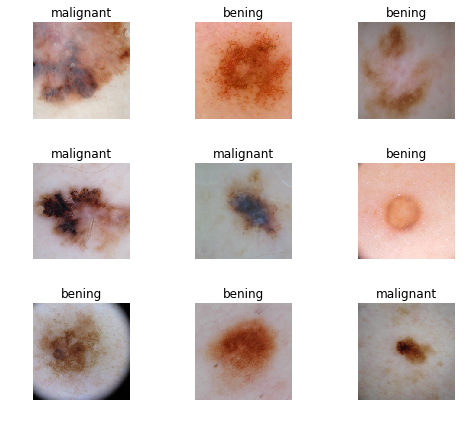

In [30]:
data.show_batch(rows=3, figsize=(7,6))


## Training: resnet34

In [31]:
# Creating CNN Resnet34 model
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [32]:
# Looking for a best learning rate (lr) 
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


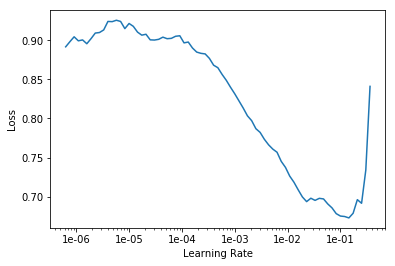

In [33]:
# Plotting lr
learn.recorder.plot()

In [34]:
# Choosing lr value as one at the steepest slope point on plot
lr = 6.31e-3

In [35]:
# Training with the new found lr
learn.fit_one_cycle(8, max_lr=slice(lr))

epoch,train_loss,valid_loss,error_rate
1,0.723130,0.509816,0.285000
2,0.632252,0.463848,0.175000
3,0.548796,0.463415,0.225000
4,0.505203,0.446572,0.195000
5,0.467833,0.448402,0.170000
6,0.424116,0.440628,0.200000
7,0.389078,0.443019,0.185000
8,0.370020,0.444284,0.190000


In [ ]:
# Saving model weights
learn.save('stage-1-224-rn34')
# learn.load('stage-1-224-rn34')

## Unfreezing and Fine-tuning

In [42]:
# Unfreezing whole model, because until now we just trained few last layers only
learn.unfreeze()

In [43]:
# Looking for the best lr range for whole model after unfreezing 
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


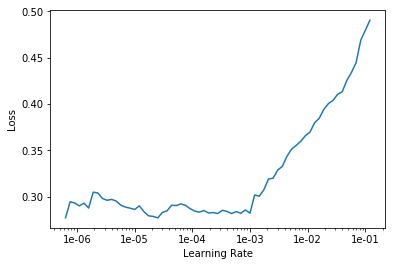

In [44]:
learn.recorder.plot()

In [45]:
# Using lr range
# Rule of thumb: first slice value is from way back before error_rate starts to worsen,
# and second value is /5 or /10 (just x10 smaller) than the one from before unfreeze
learn.fit_one_cycle(8, slice(1e-5, lr/10))

epoch,train_loss,valid_loss,error_rate
1,0.289505,0.441151,0.185000
2,0.271295,0.451707,0.210000
3,0.266056,0.433411,0.180000
4,0.239079,0.463798,0.185000
5,0.204156,0.486506,0.195000
6,0.182334,0.480659,0.180000
7,0.162342,0.483286,0.180000
8,0.152833,0.478595,0.175000


In [46]:
learn.save('stage-2-224-rn34')

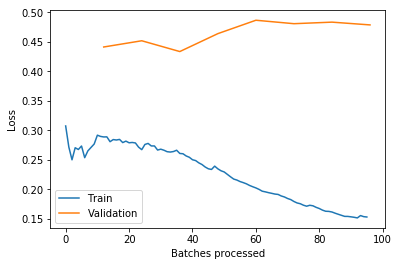

In [47]:
learn.recorder.plot_losses()

## Exchanging data with bigger images to further improve the model

In [48]:
# Creating databunch with 448px images
data = (
                  src.transform(tfms, size=448)
                     .databunch()
                     .normalize(imagenet_stats)
       )

In [49]:
# Exchanging data values
learn.data = data

In [50]:
# Freezeing the model to train only last few layers
learn.freeze()

In [51]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


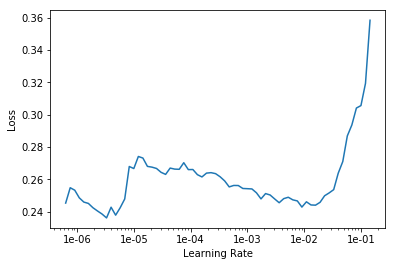

In [52]:
learn.recorder.plot()

In [53]:
lr = 5e-4

In [54]:
learn.fit_one_cycle(8, slice(lr))

epoch,train_loss,valid_loss,error_rate
1,0.284986,0.494711,0.200000
2,0.270984,0.508100,0.190000
3,0.265349,0.495148,0.195000
4,0.243024,0.479473,0.205000
5,0.239180,0.477476,0.190000
6,0.234617,0.476812,0.190000
7,0.225906,0.472030,0.190000
8,0.222390,0.474459,0.195000


In [55]:
learn.save('stage-1-448-rn34')

In [56]:
learn.unfreeze()

In [57]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


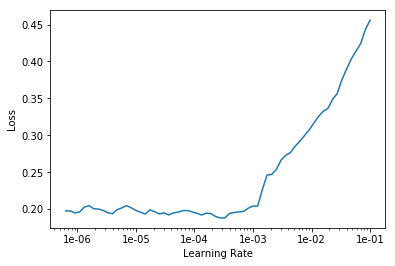

In [58]:
learn.recorder.plot()

In [59]:
learn.fit_one_cycle(8, slice(1e-6, 6e-4))

epoch,train_loss,valid_loss,error_rate
1,0.225368,0.464028,0.190000
2,0.209774,0.438711,0.175000
3,0.190223,0.454332,0.180000
4,0.182334,0.449702,0.165000
5,0.170373,0.464529,0.165000
6,0.153790,0.464571,0.170000
7,0.140524,0.478859,0.175000
8,0.131798,0.478810,0.170000


In [60]:
learn.save('stage-2-448-rn34')

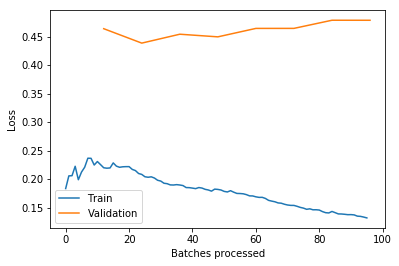

In [61]:
learn.recorder.plot_losses()

## Results

In [62]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

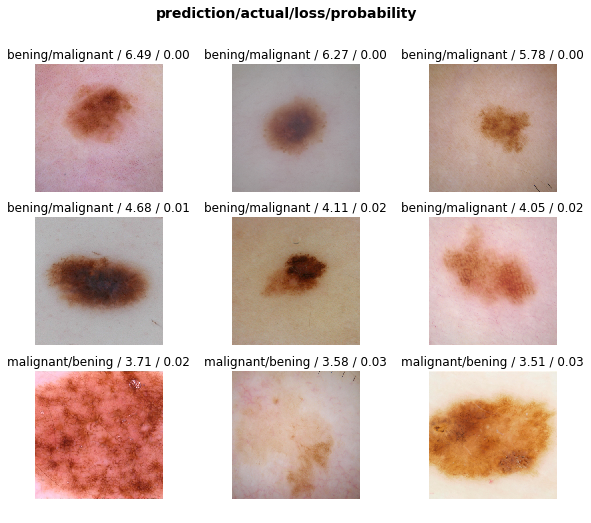

In [63]:
interp.plot_top_losses(9, figsize=(10,8))

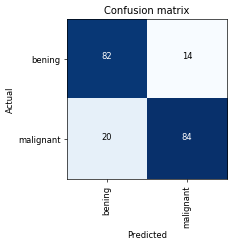

In [64]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

In [0]:
# interp.most_confused(min_val=2)